<a href="https://colab.research.google.com/github/Pety99/food101/blob/main/food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow_datasets

In [ ]:
import tensorflow as tf

In [ ]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds

import tensorflow_hub as hub
#tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers


In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Adathaémaz letöltése a TensorFlow Datasets-ről
A [food101](https://www.tensorflow.org/datasets/catalog/food101) adathalmazt fogjuk használni, amiben 101000 kép található 101 külöböző kategóriába tartozó ételről, kategóriánként 1000 képpel. Az adathalmazt elszeparáltuk egy train és egy validációs halmazra. Az adatokból, most csak az első 11 oszlopot fogjuk használni.


In [ ]:
dataset, metadata = tfds.load('food101', as_supervised=True, with_info=True)
train_dataset, validation_dataset = dataset['train'], dataset['validation']
train_dataset = train_dataset.filter(lambda img, label: label <= 10)
validation_dataset = validation_dataset.filter(lambda img, label: label <= 10)

#Pár információ az adatokról

In [ ]:
num_classes = metadata.features['label'].num_classes // 101 * 11
num_train_examples = metadata.splits['train'].num_examples // 101 * 11
num_val_examples = metadata.splits['validation'].num_examples // 101 * 11


print('Total Number of Classes: {}'.format(num_classes))
print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples:{}".format(num_val_examples))


Total Number of Classes: 11
Number of training examples: 8250
Number of validation examples:     2750


Látható, hogy nem minden kép ugyan akkora, tehát majd át kell méretezni őket.

In [ ]:
for i, example in enumerate(train_dataset.take(10)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))


Image 1 shape: (512, 512, 3) label: 10
Image 2 shape: (512, 512, 3) label: 4
Image 3 shape: (384, 512, 3) label: 2
Image 4 shape: (341, 512, 3) label: 8
Image 5 shape: (512, 512, 3) label: 9
Image 6 shape: (384, 512, 3) label: 3
Image 7 shape: (306, 512, 3) label: 8
Image 8 shape: (384, 512, 3) label: 0
Image 9 shape: (512, 512, 3) label: 4
Image 10 shape: (512, 512, 3) label: 4


Ezekből a kategóriákból fogunk képeket kiválasztani:

In [ ]:
class_names = np.array(metadata.features['label'].names)[:num_classes]

print(class_names)

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta']


#Képek átméretezése és Batchelése

Az első modellhez: [Inception ResNet V2](https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4) 299x299 es képekre van szükség, szóval át kell őket méretezni.

In [32]:
IMAGE_RES = 299

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_dataset.shuffle(num_train_examples //4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Pár kép az adatok közül

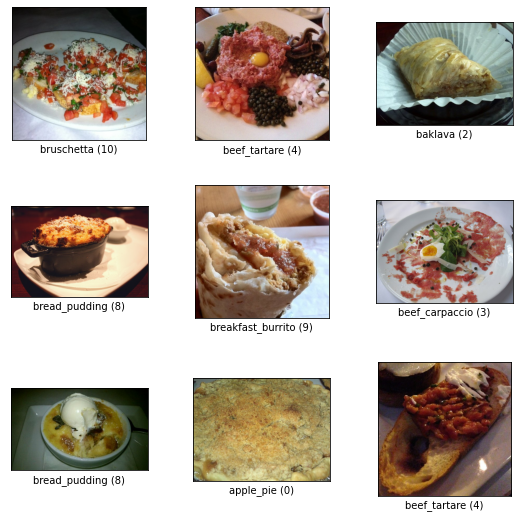

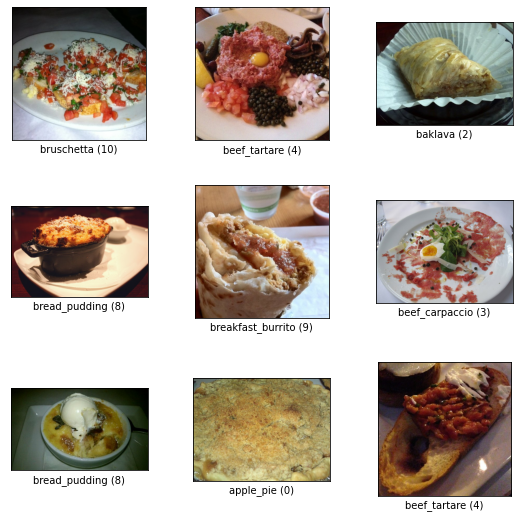

In [44]:
tfds.visualization.show_examples(
    train_dataset,
    metadata
)

# Transfer Learning
Az [Inception ResNet V2](https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4) modellt használjuk, és kibővítjük egy utolsó klasszifikáló réteggel.

In [34]:
CLASSIFIER_URL ="https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"

feature_extractor = hub.KerasLayer(CLASSIFIER_URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [35]:
feature_extractor.trainable = False

In [36]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_7 (Dense)              (None, 11)                11022     
Total params: 55,886,295
Trainable params: 11,022
Non-trainable params: 55,875,273
_________________________________________________________________


In [38]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 25

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/25
258/258 [==============================] - 268s 1s/step - loss: 0.8615 - accuracy: 0.7168 - val_loss: 0.6694 - val_accuracy: 0.7793
Epoch 2/25
258/258 [==============================] - 269s 1s/step - loss: 0.6954 - accuracy: 0.7674 - val_loss: 0.6261 - val_accuracy: 0.7960
Epoch 3/25
258/258 [==============================] - 275s 1s/step - loss: 0.6396 - accuracy: 0.7848 - val_loss: 0.5980 - val_accuracy: 0.8098
Epoch 4/25
258/258 [==============================] - 275s 1s/step - loss: 0.6025 - accuracy: 0.7982 - val_loss: 0.6080 - val_accuracy: 0.8047
Epoch 5/25
258/258 [==============================] - 274s 1s/step - loss: 0.5789 - accuracy: 0.8047 - val_loss: 0.5872 - val_accuracy: 0.8058
Epoch 6/25
258/258 [==============================] - 275s 1s/step - loss: 0.5587 - accuracy: 0.8152 - val_loss: 0.5939 - val_accuracy: 0.8040
Epoch 7/25
258/258 [==============================] - 276s 1s/step - loss: 0.5398 - accuracy: 0.8165 - val_loss: 0.5898 - val_accuracy: 0.8124

# Eredmények

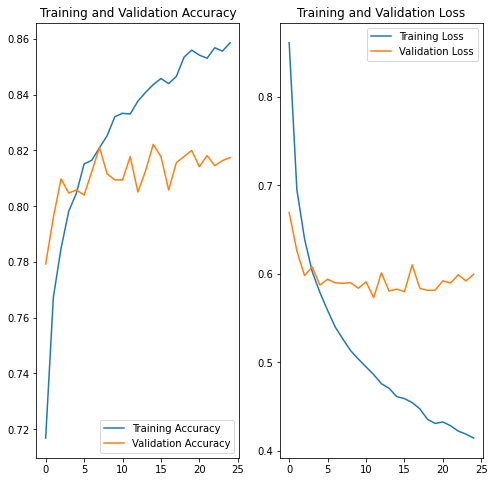

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(IMAGE_RES, IMAGE_RES, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

In [41]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 299, 299, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 149, 149, 128)     73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 74, 74, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 256)      

In [43]:
epochs=10
history = model2.fit_generator(
    train_batches,
    steps_per_epoch=int(np.ceil(num_train_examples / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=validation_batches,
    validation_steps=int(np.ceil(num_val_examples / float(BATCH_SIZE)))
)

Epoch 1/10
258/258 [==============================] - 231s 897ms/step - loss: 2.4521 - accuracy: 0.0903 - val_loss: 2.4521 - val_accuracy: 0.0909
Epoch 2/10
  0/258 [..............................] - 0s 0s/step - loss: 2.4521 - accuracy: 0.0903 - val_loss: 2.4521 - val_accuracy: 0.0909
